In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile, os

zip_path = "/content/drive/MyDrive/d.zip"
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(" Dataset extracted.")

 Dataset extracted.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3  # 🔄 Changed from ResNet152 to InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
train_dir = "/content/dataset/d/train"
val_dir   = "/content/dataset/d/val"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

# === Data generators (DenseNet201-friendly) ===
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

# === Load image data ===
BATCH_SIZE = 32

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),   # standard DenseNet201 input size (recommended)
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),   # standard DenseNet201 input size (recommended)
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# --- DenseNet201 backbone (recommended input size 224x224) ---
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# --- Option A: simple and safe freeze strategy ---
# Freeze all base layers initially, then unfreeze the last N layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

N = 50  # number of last base layers to unfreeze for fine-tuning (tune as needed)
for layer in base_model.layers[-N:]:
    layer.trainable = True

# --- Option B: dynamic split based on a fraction of layers (alternative) ---
# total_layers = len(base_model.layers)
# split_fraction = 0.60  # keep first 60% frozen, fine-tune last 40%
# split_idx = int(total_layers * split_fraction)
# for layer in base_model.layers[:split_idx]:
#     layer.trainable = False
# for layer in base_model.layers[split_idx:]:
#     layer.trainable = True

# --- Custom classification head (preserves your original head) ---
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# --- Training hyperparameters ---
BATCH_SIZE = 32                  # keep consistent with your generator
phase1_epochs = 21              # head-only training
phase2_epochs = 21               # fine-tuning (total = 21 as before)
total_epochs = phase1_epochs + phase2_epochs

# --- Callbacks ---
checkpoint_phase1 = ModelCheckpoint(
    "/content/drive/MyDrive/best_densenet201_head.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

checkpoint_phase2 = ModelCheckpoint(
    "/content/drive/MyDrive/best_densenet201_finetuned.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# ---------- PHASE 1 : Train head only (backbone frozen) ----------
# Ensure backbone is fully frozen for phase 1
for layer in base_model.layers:
    layer.trainable = False

# Compile with Adam for head training
optimizer_phase1 = Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer_phase1,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Ensure model input shape matches DenseNet201 preprocessing (224x224)
model.build((None, 224, 224, 3))

# Fit head
history_phase1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=phase1_epochs,
    callbacks=[checkpoint_phase1, lr_scheduler],
    verbose=1
)

# ---------- PHASE 2 : Unfreeze last N layers and fine-tune ----------
# Unfreeze a configurable number of layers from the backbone
N = 50  # adjust based on dataset size and compute; 20-100 is common
for layer in base_model.layers[-N:]:
    layer.trainable = True

# It is recommended to keep earlier layers frozen to preserve low-level features
for layer in base_model.layers[:-N]:
    layer.trainable = False

# Recompile with a lower learning rate using SGD for fine-tuning
optimizer_phase2 = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
model.compile(
    optimizer=optimizer_phase2,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_phase2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=total_epochs,
    initial_epoch=phase1_epochs,
    callbacks=[checkpoint_phase2, lr_scheduler],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.6304 - loss: 1.1972
Epoch 1: val_loss improved from inf to 0.49444, saving model to /content/drive/MyDrive/best_densenet201_head.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6318 - loss: 1.1936 - val_accuracy: 0.8470 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 2/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8526 - loss: 0.5125
Epoch 2: val_loss improved from 0.49444 to 0.35535, saving model to /content/drive/MyDrive/best_densenet201_head.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 650ms/step - accuracy: 0.8524 - loss: 0.5127 - val_accuracy: 0.8530 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 3/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8563 - loss: 0.3970
Epoch 3: val_loss improved from 0.35535 to 0.30972, saving model to /content/drive/MyDrive/best_densenet201_head.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 653ms/step - accuracy: 0.8564 - loss: 0.3968 - val_accuracy: 0.8712 - val_lo

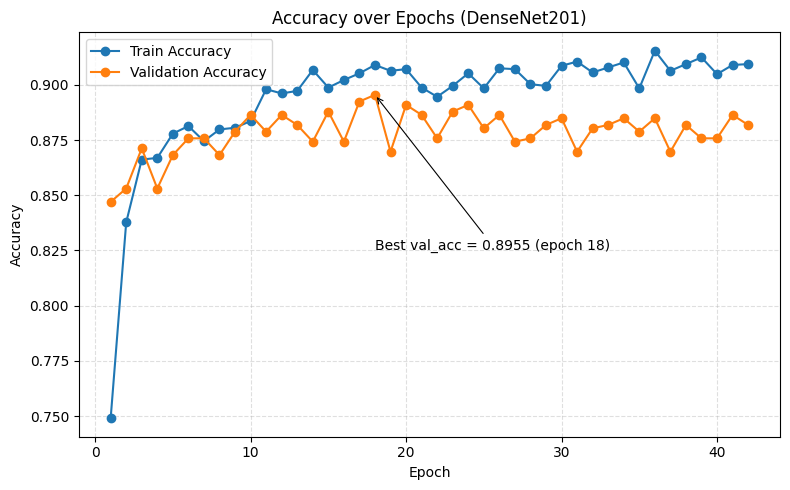

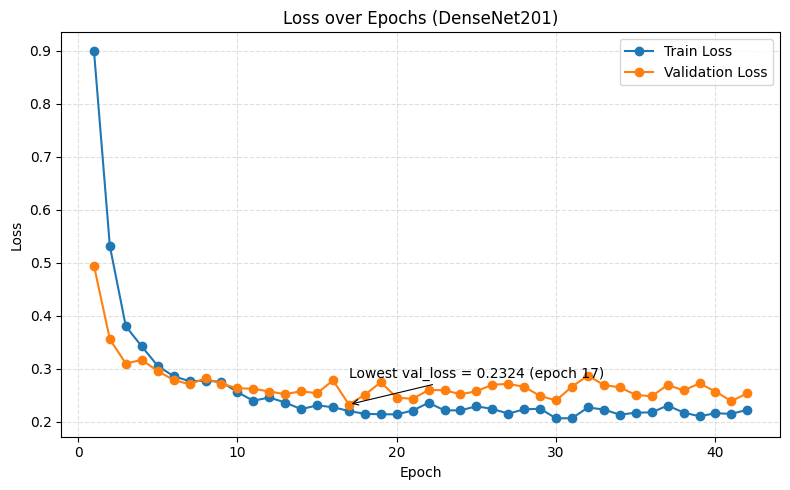

Saved accuracy plot to: /content/drive/MyDrive/diabetic_eye_results/densenet201_accuracy_plot.png
Saved loss plot to:     /content/drive/MyDrive/diabetic_eye_results/densenet201_loss_plot.png


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# --- Collect available histories (works for single or two-phase training) ---
histories = []

try:
    # phase1 and phase2 names from the two-phase example
    histories.append(history_phase1.history)
except NameError:
    pass

try:
    histories.append(history_phase2.history)
except NameError:
    pass

# fallback to single `history` variable if present
if not histories:
    try:
        histories.append(history.history)
    except NameError:
        raise RuntimeError("No training history found. Ensure `history`, `history_phase1`, or `history_phase2` exist in the current scope.")

# --- Helper to concatenate metric lists across phases ---
def concat_metric(metric_name):
    concatenated = []
    for h in histories:
        if metric_name in h:
            concatenated.extend(h[metric_name])
    return concatenated

train_acc = concat_metric('accuracy')
val_acc   = concat_metric('val_accuracy')
train_loss = concat_metric('loss')
val_loss   = concat_metric('val_loss')

num_epochs = len(train_acc)
epochs = np.arange(1, num_epochs + 1)

# --- Plot Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
if val_acc:
    plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title("Accuracy over Epochs (DenseNet201)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='best')

# Annotate best validation accuracy if available
if val_acc:
    best_idx = int(np.argmax(val_acc))  # zero-based
    best_val = val_acc[best_idx]
    plt.annotate(f"Best val_acc = {best_val:.4f} (epoch {best_idx+1})",
                 xy=(best_idx+1, best_val),
                 xytext=(best_idx+1, best_val - 0.07 if best_val > 0.2 else best_val + 0.02),
                 arrowprops=dict(arrowstyle="->", lw=0.8))
plt.tight_layout()
acc_path = os.path.join(graph_dir, "densenet201_accuracy_plot.png")
plt.savefig(acc_path, dpi=150)
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
if val_loss:
    plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title("Loss over Epochs (DenseNet201)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='best')

# Annotate lowest validation loss if available
if val_loss:
    best_loss_idx = int(np.argmin(val_loss))
    best_loss = val_loss[best_loss_idx]
    plt.annotate(f"Lowest val_loss = {best_loss:.4f} (epoch {best_loss_idx+1})",
                 xy=(best_loss_idx+1, best_loss),
                 xytext=(best_loss_idx+1, best_loss + 0.05 if best_loss < 1.0 else best_loss - 0.05),
                 arrowprops=dict(arrowstyle="->", lw=0.8))
plt.tight_layout()
loss_path = os.path.join(graph_dir, "densenet201_loss_plot.png")
plt.savefig(loss_path, dpi=150)
plt.show()

print(f"Saved accuracy plot to: {acc_path}")
print(f"Saved loss plot to:     {loss_path}")


✅ Model loaded from: /content/drive/MyDrive/best_densenet201_finetuned.keras
Validation samples: 660, Batch size: 32, Predict steps: 21
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
Unique y_true labels present: [0 1]
Unique y_pred labels present: [0 1]
Class indices: {'benign': 0, 'malignant': 1}
Target names (sorted by index): ['benign', 'malignant']

Predicted sample count per class:
  benign: 360
  malignant: 300

✅ Overall Validation Accuracy: 89.39%


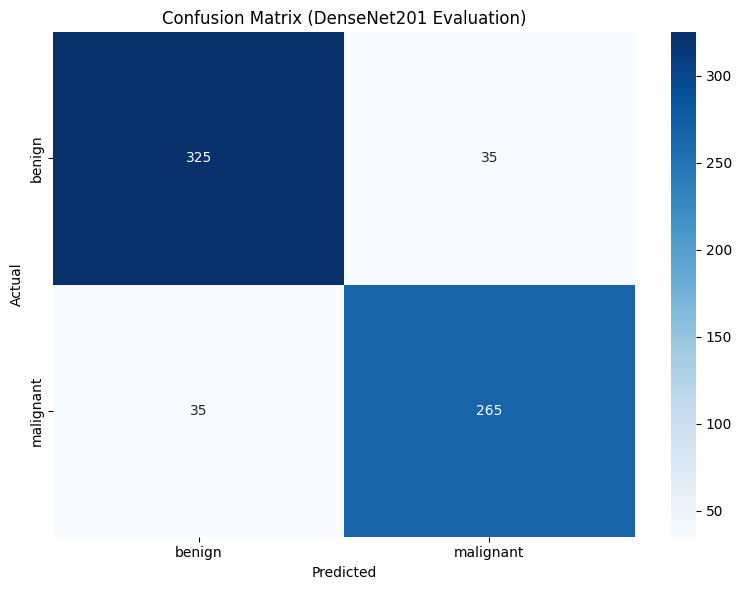

Saved confusion matrix to: /content/drive/MyDrive/diabetic_eye_results/densenet201_confusion_matrix.png

Classification Report:

              precision    recall  f1-score   support

      benign       0.90      0.90      0.90       360
   malignant       0.88      0.88      0.88       300

    accuracy                           0.89       660
   macro avg       0.89      0.89      0.89       660
weighted avg       0.89      0.89      0.89       660

Saved classification report to: /content/drive/MyDrive/diabetic_eye_results/densenet201_classification_report.txt


In [11]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import load_model

# === Paths (tries finetuned DenseNet201 first, then head-only checkpoint) ===
preferred_paths = [
    "/content/drive/MyDrive/best_densenet201_finetuned.keras",
    "/content/drive/MyDrive/best_densenet201_head.keras",
    "/content/drive/MyDrive/best_inceptionv3_model.keras"  # fallback if you still have it
]

model = None
for p in preferred_paths:
    if os.path.exists(p):
        try:
            model = load_model(p, compile=False)  # compile=False avoids custom-object issues
            model_path = p
            print(f"✅ Model loaded from: {p}")
            break
        except Exception as e:
            print(f"Warning: failed to load model at {p}: {e}")

if model is None:
    raise FileNotFoundError(f"No model found at any of the expected locations: {preferred_paths}")

# === Directory to save results ===
graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# === Prepare validation generator and compute steps ===
# Ensure val_data has shuffle=False so y_true lines up with predictions
try:
    val_samples = val_data.samples
    batch_size = val_data.batch_size
except NameError:
    raise RuntimeError("`val_data` is not defined in the current scope. Ensure the validation generator `val_data` exists.")

steps = int(math.ceil(val_samples / float(batch_size)))
print(f"Validation samples: {val_samples}, Batch size: {batch_size}, Predict steps: {steps}")

# === Predict on validation data (use steps to cover all samples) ===
val_data.reset()
pred_probs = model.predict(val_data, steps=steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# In case the generator yields more samples than val_samples due to rounding, trim predictions
if len(y_pred) > val_samples:
    y_pred = y_pred[:val_samples]

# True labels
y_true = val_data.classes
if len(y_true) > val_samples:
    y_true = y_true[:val_samples]

# === Class mapping and target names ===
class_indices = val_data.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
valid_labels = sorted(index_to_label.keys())
target_names = [index_to_label[i] for i in valid_labels]

# === Debug information ===
print("Unique y_true labels present:", np.unique(y_true))
print("Unique y_pred labels present:", np.unique(y_pred))
print("Class indices:", class_indices)
print("Target names (sorted by index):", target_names)

# === Predicted sample counts per class ===
print("\nPredicted sample count per class:")
pred_counter = collections.Counter(y_pred)
for label in valid_labels:
    print(f"  {index_to_label[label]}: {pred_counter.get(label, 0)}")

# === Overall accuracy ===
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Validation Accuracy: {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (DenseNet201 Evaluation)")
plt.tight_layout()
conf_mat_path = os.path.join(graph_dir, "densenet201_confusion_matrix.png")
plt.savefig(conf_mat_path, dpi=150)
plt.show()
print(f"Saved confusion matrix to: {conf_mat_path}")

# === Classification report (printed + saved) ===
report = classification_report(
    y_true,
    y_pred,
    labels=valid_labels,
    target_names=target_names,
    zero_division=0
)
print("\nClassification Report:\n")
print(report)

report_path = os.path.join(graph_dir, "densenet201_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Model path: {model_path}\n")
    f.write(f"Validation samples: {val_samples}\n\n")
    f.write(report)
print(f"Saved classification report to: {report_path}")


⚠️ Skipping ROC curve for Class 2 — no positive samples in y_true.
⚠️ Skipping ROC curve for Class 3 — no positive samples in y_true.
⚠️ Skipping ROC curve for Class 4 — no positive samples in y_true.


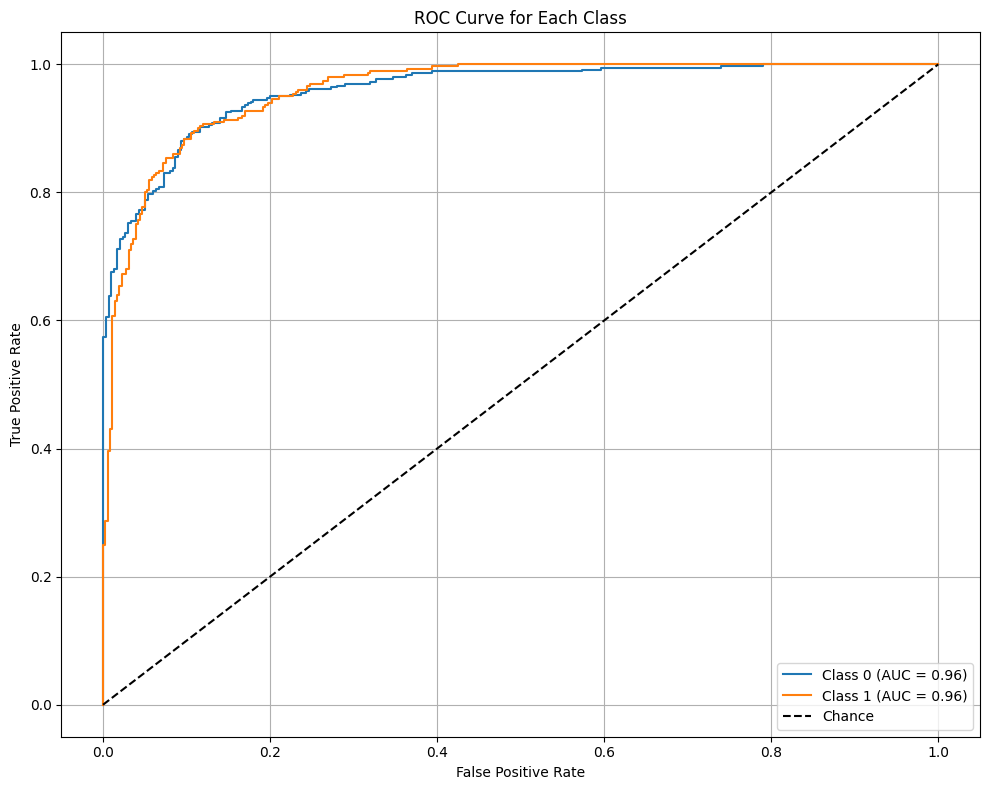


Skipped ROC for classes with no positive samples: Class 2, Class 3, Class 4
✅ ROC curve saved to: ./plots/roc_curve.png


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import os

# ---------- Required Inputs ----------
# y_true: true labels (e.g., [0, 2, 1, 4, ...]), shape = (n_samples,)
# pred_probs: predicted probabilities, shape = (n_samples, n_classes)
# labels: class names (optional, replace with your own)
# graph_dir: directory where to save plot

n_classes = 5
labels = [f'Class {i}' for i in range(n_classes)]  # Replace with actual names if needed
graph_dir = "./plots"

# Ensure output directory exists
os.makedirs(graph_dir, exist_ok=True)

# Binarize true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Dictionaries to store ROC metrics
fpr, tpr, roc_auc = {}, {}, {}
missing_classes = []

# Compute ROC for each class
for i in range(n_classes):
    if np.sum(y_true_bin[:, i]) == 0:
        print(f"⚠️ Skipping ROC curve for {labels[i]} — no positive samples in y_true.")
        missing_classes.append(labels[i])
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Save and show plot
plot_path = os.path.join(graph_dir, "roc_curve.png")
plt.savefig(plot_path)
plt.show()

# ---------- Summary ----------
if missing_classes:
    print(f"\nSkipped ROC for classes with no positive samples: {', '.join(missing_classes)}")
print(f"✅ ROC curve saved to: {plot_path}")


In [17]:
model.save("/content/drive/MyDrive/final_resnet152_model.keras")